In [2]:
import numpy as np
import time
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision
from torch import nn, optim
from torchsummary import summary
import torch.utils.data as data_utils


In [3]:
projectDevice = "cuda" if torch.cuda.is_available() else "cpu"
batchSize = 32
numEpochs = 10
learningRate = 0.01
inputSize = (1,28,28)

In [4]:
def process_x(x):
  x = x.type(torch.float32)

  # Normalize the data between [-1.0, 1.0]
  x /= 127.5
  x -= 1.0
  x = torch.unsqueeze(x, dim=1) # [NxHxW] -> [CxHxW] for PyTorch
  return x

def load_data(ds=torchvision.datasets.MNIST):
  training, test = ds('./data/mnist', download=True), ds('./data/mnist', download=True, train=False)
  train_images, train_labels = process_x(training.data), training.targets
  test_images, test_labels = process_x(test.data), test.targets

  return (train_images, train_labels), (test_images, test_labels)

In [5]:
(train_x, train_y), (test_x, test_y) = load_data()

In [6]:
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(CNN, self).__init__()

        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32,
                            kernel_size=3)
        self.conv_layer2 = nn.Conv2d(32, 64, 3)
        self.fc = nn.Linear(in_features= 64*5*5, out_features=10)

        self.batch_norm1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.batch_norm2 = nn.BatchNorm2d(64)

        self.flat = nn.Flatten()
        self.drop = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        # x.shape = BxCxHxW

        # Block 1
        out = self.conv_layer1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.pool(out)

        # Block 2
        out = self.conv_layer2(out)
        out = self.batch_norm2(out)
        out = self.relu(out)
        out = self.pool(out)

        out = self.flat(out)
        out = self.drop(out)
        out = self.fc(out)

        return out


In [7]:
def train_model(model, epochs, batchSize, device=projectDevice):
  model_history = {"loss":[], "sparse_categorical_accuracy": [],
                   "val_loss":[], "val_sparse_categorical_accuracy":[]}

  model.to(device)
  summary(model, input_size=inputSize, device=device)

  optimizer = optim.Adam(model.parameters(), lr=learningRate)
  criterion = nn.CrossEntropyLoss()

  train = data_utils.TensorDataset(train_x, train_y)
  train_loader = data_utils.DataLoader(train, batch_size=batchSize, shuffle=True)

  val = data_utils.TensorDataset(test_x, test_y)
  val_loader = data_utils.DataLoader(val, batch_size=batchSize, shuffle=False)

  for epoch in range(epochs):

    start = time.time()
    print(f'Epoch {epoch+1}')
    train_loss = 0.0
    train_correct = 0.0

    val_loss = 0.0
    val_correct = 0.0

    model.train()

    for data in tqdm(train_loader):

        x, y = data
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += outputs.shape[0] * loss.item()
        train_correct += (outputs.argmax(1) == y).detach().cpu().sum()

    train_loss = train_loss/float(len(train_x))
    train_correct = train_correct/float(len(train_x))

    model_history["loss"].append(train_loss)
    model_history["sparse_categorical_accuracy"].append(train_correct)

    model.eval()
    with torch.no_grad():

      for data in val_loader:
          x, y = data
          x, y = x.to(device), y.to(device)

          outputs = model(x)
          loss = criterion(outputs, y)

          val_loss += outputs.shape[0] * loss.item()
          val_correct += (outputs.argmax(1) == y).detach().cpu().sum()

    val_loss = val_loss/float(len(test_x))
    val_correct = val_correct/float(len(test_x))

    model_history["val_loss"].append(val_loss)
    model_history["val_sparse_categorical_accuracy"].append(val_correct)

    end = time.time()

    print(f"Time: {(end-start):.2f} s  - ",
          f"Loss: {train_loss:.4f}  -  Categorical_Accuracy: {train_correct:.4f}  - ",
          f"Val_Loss: {val_loss:.4f}  -  Categorical_Val_Accuracy: {val_correct:.4f}")

  print('Finished Training')

  return model, model_history

In [8]:
modelCNN = CNN()
modelCNN, modelCNNHistory = train_model(modelCNN, numEpochs, batchSize, projectDevice)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─Linear: 1-3                            16,010
├─BatchNorm2d: 1-4                       64
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─BatchNorm2d: 1-7                       128
├─Flatten: 1-8                           --
├─Dropout: 1-9                           --
Total params: 35,018
Trainable params: 35,018
Non-trainable params: 0
Epoch 1


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 20.26 s  -  Loss: 0.1610  -  Categorical_Accuracy: 0.9634  -  Val_Loss: 0.0632  -  Categorical_Val_Accuracy: 0.9788
Epoch 2


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 21.71 s  -  Loss: 0.0501  -  Categorical_Accuracy: 0.9845  -  Val_Loss: 0.0526  -  Categorical_Val_Accuracy: 0.9825
Epoch 3


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 22.81 s  -  Loss: 0.0449  -  Categorical_Accuracy: 0.9866  -  Val_Loss: 0.0394  -  Categorical_Val_Accuracy: 0.9870
Epoch 4


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 22.88 s  -  Loss: 0.0390  -  Categorical_Accuracy: 0.9884  -  Val_Loss: 0.0353  -  Categorical_Val_Accuracy: 0.9894
Epoch 5


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 26.25 s  -  Loss: 0.0345  -  Categorical_Accuracy: 0.9891  -  Val_Loss: 0.0463  -  Categorical_Val_Accuracy: 0.9871
Epoch 6


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 24.57 s  -  Loss: 0.0318  -  Categorical_Accuracy: 0.9903  -  Val_Loss: 0.0504  -  Categorical_Val_Accuracy: 0.9874
Epoch 7


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 26.52 s  -  Loss: 0.0277  -  Categorical_Accuracy: 0.9916  -  Val_Loss: 0.0525  -  Categorical_Val_Accuracy: 0.9890
Epoch 8


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 22.35 s  -  Loss: 0.0262  -  Categorical_Accuracy: 0.9924  -  Val_Loss: 0.0520  -  Categorical_Val_Accuracy: 0.9880
Epoch 9


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 21.74 s  -  Loss: 0.0253  -  Categorical_Accuracy: 0.9926  -  Val_Loss: 0.0451  -  Categorical_Val_Accuracy: 0.9882
Epoch 10


  0%|          | 0/1875 [00:00<?, ?it/s]

Time: 22.18 s  -  Loss: 0.0225  -  Categorical_Accuracy: 0.9935  -  Val_Loss: 0.0680  -  Categorical_Val_Accuracy: 0.9862
Finished Training


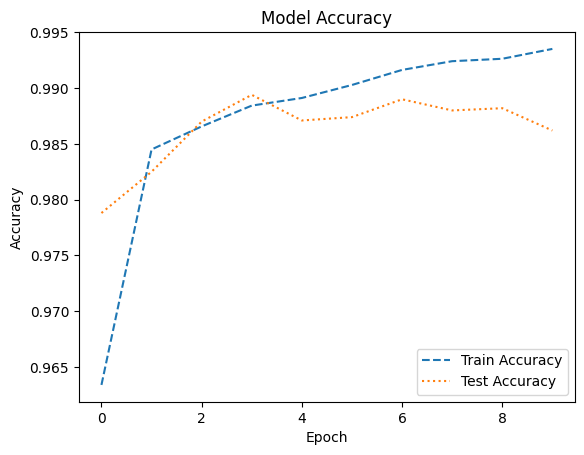

In [9]:
plt.plot(
    modelCNNHistory['sparse_categorical_accuracy'],
    linestyle='dashed')
plt.plot(
    modelCNNHistory['val_sparse_categorical_accuracy'],
    linestyle='dotted')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
plt.show()

In [10]:
# from tqdm import tqdm

def optimized_modelEval(model, test_images, test_labels, device='cpu', batch_size=64):

    num_correct = 0
    num_total = 0

    model.to(device)
    model.eval()

    # Create a DataLoader for the test data
    test_data = torch.utils.data.TensorDataset(test_images, test_labels)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    with torch.no_grad():
        # Initialize the progress bar
        pbar = tqdm(total=len(test_loader), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
        
        for i, (inputs, labels) in enumerate(test_loader):
            start = time.time()

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            num_total += labels.size(0)
            num_correct += (predicted == labels).sum().item()

            end = time.time()

            # Update the progress bar
            pbar.set_description(f'Batch {i+1} Eval time: {end-start:.10f}s', refresh=True)
            pbar.update()

        pbar.close()

    print('Average time per batch:', (end-start)/len(test_loader))
    print('Accuracy:', num_correct * 1.0 / num_total)


In [11]:
start = time.time()
optimized_modelEval(modelCNN, test_x, test_y, projectDevice)
end = time.time()
print(f'Eval time: {end-start:.2f}s')

  0%|          | 0/157 [00:00<?, ?it/s]

Average time per batch: 2.0154722177298963e-05
Accuracy: 0.9862
Eval time: 1.56s


In [12]:
import resource
memory_usage = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
print("Memory Usage: Optimised", memory_usage)

Memory Usage: Optimised 610553856
